In [1]:
import pandas as pd

# Imports for the confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sms_spam = pd.read_csv('spam.csv', encoding='latin-1', usecols=[0, 1])
sms_spam.rename(columns={'v1': 'Label', 'v2': 'SMS'}, inplace=True)
print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms_spam['Label'].value_counts(normalize=True)

Label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

In [4]:
# Randomize the dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Split into training and test sets
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [5]:
training_set['Label'].value_counts(normalize=True)

Label
ham     0.864065
spam    0.135935
Name: proportion, dtype: float64

In [6]:
test_set['Label'].value_counts(normalize=True)

Label
ham     0.873429
spam    0.126571
Name: proportion, dtype: float64

In [7]:
training_set.head(3)

,Label,SMS
0,ham,Convey my regards to him
1,ham,"[Û_] anyway, many good evenings to u! s"
2,ham,My sort code is and acc no is . The bank is n...


In [8]:
# Data Cleaning
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ') # Removes punctuation
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head(3)

,Label,SMS
0,ham,convey my regards to him
1,ham,"[û_] anyway, many good evenings to u! s"
2,ham,my sort code is and acc no is . the bank is n...


In [9]:
# Build vocabulary
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
   for word in sms:
      vocabulary.append(word)

vocabulary = list(set(vocabulary))

In [10]:
len(vocabulary)

11768

In [11]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
   for word in sms:
      word_counts_per_sms[word][index] += 1

In [12]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,link,play.,october.,":-):-).""",goggles,am,falls,studentfinancial,indeed,wannatell,...,lovable,defo,hee..,"dudette,",creative.,php,09058094583,xmas,necklace,"again,"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,Label,SMS,link,play.,october.,":-):-).""",goggles,am,falls,studentfinancial,...,lovable,defo,hee..,"dudette,",creative.,php,09058094583,xmas,necklace,"again,"
0,ham,"[convey, my, regards, to, him]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[[û_], anyway,, many, good, evenings, to, u!, s]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[my, sort, code, is, and, acc, no, is, ., the,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,"[sorry, i, din, lock, my, keypad.]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,"[hi, babe, its, chloe,, how, r, u?, i, was, sm...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

In [15]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
   n_word_given_spam = spam_messages[word].sum()
   p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
   parameters_spam[word] = p_word_given_spam

   n_word_given_ham = ham_messages[word].sum()
   p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
   parameters_ham[word] = p_word_given_ham

In [16]:
import re

def classify(message):
   '''
   Classify a message text as either ham or spam
   message: a string
   '''

   message = re.sub('\W', ' ', message)
   message = message.lower().split()

   p_spam_given_message = p_spam
   p_ham_given_message = p_ham

   for word in message:
      if word in parameters_spam:
         p_spam_given_message *= parameters_spam[word]

      if word in parameters_ham: 
         p_ham_given_message *= parameters_ham[word]

   print('P(Spam|message):', p_spam_given_message)
   print('P(Ham|message):', p_ham_given_message)

   if p_ham_given_message > p_spam_given_message:
      print('Label: Ham')
   elif p_ham_given_message < p_spam_given_message:
      print('Label: Spam')
   else:
      print('Cannot be determined!')


In [17]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 5.6305750462656825e-27
P(Ham|message): 1.080046038974544e-27
Label: Spam


In [18]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 4.4729667224361027e-26
P(Ham|message): 9.644217785124867e-22
Label: Ham


In [19]:
def classify_test_set(message):
   '''
   Classify test set messages as spam or ham
   message: a string
   '''

   message = re.sub('\W', ' ', message)
   message = message.lower().split()

   p_spam_given_message = p_spam
   p_ham_given_message = p_ham

   for word in message:
      if word in parameters_spam:
         p_spam_given_message *= parameters_spam[word]

      if word in parameters_ham:
         p_ham_given_message *= parameters_ham[word]

   if p_ham_given_message > p_spam_given_message:
      return 'ham'
   elif p_spam_given_message > p_ham_given_message:
      return 'spam'
   else:
      return 'Cannot be determined'


In [20]:
test_set['Predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,Predicted
0,ham,S...from the training manual it show there is ...,ham
1,spam,Do you want a new Video phone? 600 anytime any...,spam
2,ham,True. Its easier with her here.,ham
3,ham,Midnight at the earliest,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [21]:
# Modify the loop to calculate TP, TN, FP, FN
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == 'ham' and row['Predicted'] == 'ham':
        tn += 1
    elif row['Label'] == 'spam' and row['Predicted'] == 'spam':
        tp += 1
    elif row['Label'] == 'ham' and row['Predicted'] == 'spam':
        fp += 1
    elif row['Label'] == 'spam' and row['Predicted'] == 'ham':
        fn += 1

correct = tp + tn
total = tp + tn + fp + fn

In [22]:
# Modify the loop to calculate TP, TN, FP, FN
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == 'ham' and row['Predicted'] == 'ham':
        tn += 1
    elif row['Label'] == 'spam' and row['Predicted'] == 'spam':
        tp += 1
    elif row['Label'] == 'ham' and row['Predicted'] == 'spam':
        fp += 1
    elif row['Label'] == 'spam' and row['Predicted'] == 'ham':
        fn += 1

correct = tp + tn
total = tp + tn + fp + fn

[[971   2]
 [  7 134]]


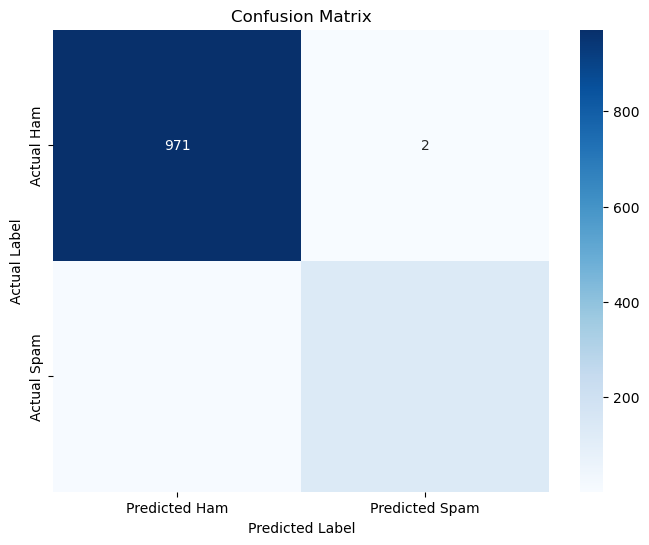

In [23]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])
print(confusion_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Performance Metrics
support_ham = tn + fp  # Total actual Ham messages
support_spam = tp + fn  # Total actual Spam messages

precision_ham = tn / (tn + fn) if (tn + fn) != 0 else 0
recall_ham = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_score_ham = 2 * (precision_ham * recall_ham) / (precision_ham + recall_ham) if (precision_ham + recall_ham) != 0 else 0

# For Spam:
precision_spam = tp / (tp + fp) if (tp + fp) != 0 else 0
recall_spam = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score_spam = 2 * (precision_spam * recall_spam) / (precision_spam + recall_spam) if (precision_spam + recall_spam) != 0 else 0

# Overall accuracy remains the same
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0

report = f"""
                precision    recall  f1-score   support

         ham       {precision_ham:.2f}      {recall_ham:.2f}      {f1_score_ham:.2f}       {support_ham}
        spam       {precision_spam:.2f}      {recall_spam:.2f}      {f1_score_spam:.2f}       {support_spam}

    accuracy                           {accuracy:.2f}       {support_ham + support_spam}
    """
print(report)


                precision    recall  f1-score   support

         ham       0.99      1.00      1.00       973
        spam       0.99      0.95      0.97       141

    accuracy                           0.99       1114
    
